# Milestone 3: EDA, Planning, and Setting Goals

 Table of Contents
- [Data Description](#data-description)
- [Summary of the Data](#summary-of-the-data)
- [Data Analysis](#data-analysis)
- [(Revised) Project Question](#project-question)
- [Baseline Model and Implementation Plan](#baseline-model)

<a name="data-description"></a>
# Data Description

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno

import scipy.stats as ss
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/AC209b_Paediatric_Appendicitis/app_data_scaled_one_to_many.pkl'

df = pd.read_pickle(file_path)

Following feedback from Milestone 2, we revisited how ultrasound images are matched to the tabular data. Since each patient can have multiple ultrasound views (1–15 per case), the dataset forms a one-to-many relationship. We linked image paths to patient records using the `US_Number` field, ensuring that each image is matched with the correct diagnostic label (`Diagnosis`) and corresponding clinical features. This structure supports a multimodal approach, allowing us to use both imaging and clinical data during training.

count    572.000000
mean       4.681818
std        4.138599
min        1.000000
25%        2.000000
50%        4.000000
75%        6.000000
max       34.000000
Name: Image_Count, dtype: float64


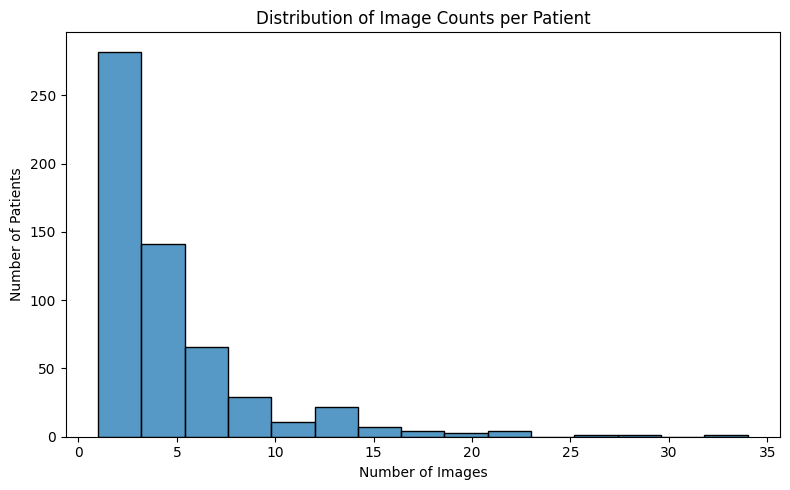

In [4]:
# group by patient (US_Number) and count how many images are associated with each
image_counts = df.groupby('US_Number')['image_path'].count().reset_index()
image_counts.columns = ['US_Number', 'Image_Count']

print(image_counts['Image_Count'].describe())

plt.figure(figsize=(8, 5))
sns.histplot(image_counts['Image_Count'], bins=15)
plt.title("Distribution of Image Counts per Patient")
plt.xlabel("Number of Images")
plt.ylabel("Number of Patients")
plt.tight_layout()
plt.show()

The distribution of image counts per patient confirms the one-to-many structure of the dataset, with 572 unique patients each linked to between 1 and 34 ultrasound images. On average, each patient has approximately 4.7 images (median = 4), with the majority having fewer than 6. A small subset of patients contributes a disproportionately high number of images, which introduces variability in sampling and potential bias if not handled properly. These patterns directly inform how we design our multimodal model: we must ensure that each image is matched to the correct clinical context and consider how to balance patients during training. To address this, we plan to either sample a fixed number of images per patient or aggregate image features at the patient level, ensuring no individual case is overrepresented.

In [ ]:
# make sure each image inherits the correct diagnosis
# check if any patient has mixed diagnoses across images (which shouldn't happen)

diagnosis_check = df.groupby('US_Number')['Diagnosis'].nunique()
inconsistent = diagnosis_check[diagnosis_check > 1]
print(f"Number of patients with conflicting diagnoses: {len(inconsistent)}")


Number of patients with conflicting diagnoses: 0


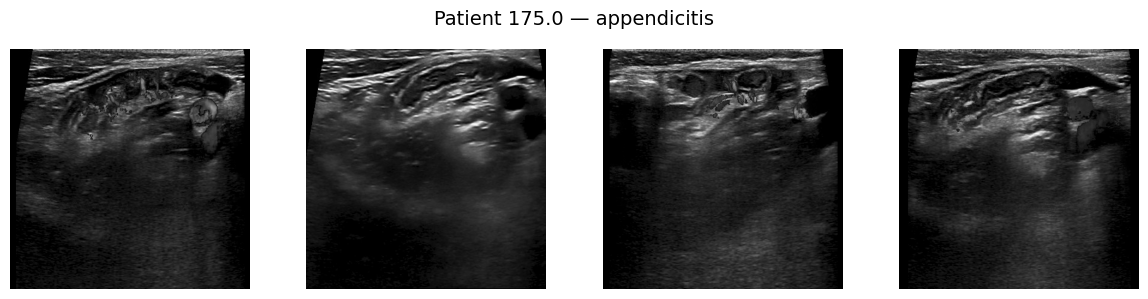

,Feature,Value
0,Appendix_Diameter,-0.105967
1,RBC_in_Urine,no
2,Ketones_in_Urine,no
3,WBC_in_Urine,no
4,Neutrophil_Percentage,0.537816
5,Free_Fluids,yes
6,Paedriatic_Appendicitis_Score,0.520189
7,Alvarado_Score,1.581349
8,Psoas_Sign,yes
9,Dysuria,no


In [ ]:
exclude_cols = ['Diagnosis', 'Severity', 'Management', 'image_path', 'normalized_image', 'US_Number']
all_features = [col for col in df.columns if col not in exclude_cols]

patient_image_counts = df['US_Number'].value_counts()
sample_id = patient_image_counts[patient_image_counts == 4].index[0]
sample_rows = df[df['US_Number'] == sample_id]

# plot image grid
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i, (_, row) in enumerate(sample_rows.iterrows()):
    img = np.array(row['normalized_image'])
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')

plt.suptitle(f"Patient {sample_id} — {sample_rows.iloc[0]['Diagnosis']}", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

# display patient summary
summary_df = sample_rows.iloc[0][all_features].to_frame(name="Value").reset_index()
summary_df.columns = ["Feature", "Value"]
display(summary_df)

<a name="summary-of-the-data"></a>
# Summary of the Data

The dataset includes 2678 pediatric patient records, each described by 35 features. These include demographics, clinical symptoms, lab results, ultrasound findings, and three target variables. The primary classification target is `Diagnosis` (appendicitis vs. no appendicitis), with additional labels for `Severity` and `Management`.

#### Demographics
- **Age**: Standardized patient age  
- **Sex**: Biological sex  
- **BMI**: Body mass index, calculated from height and weight  

#### Symptoms and Physical Signs
- **Coughing_Pain**: Pain triggered or worsened by coughing  
- **Psoas_Sign**: Pain with hip extension, suggests inflammation near the appendix  
- **Contralateral_Rebound_Tenderness**: Pain when pressure is released on the opposite side of the abdomen  
- **Lower_Right_Abd_Pain**: Localized pain in the lower right abdomen  
- **Migratory_Pain**: Pain that started elsewhere and moved to the lower right abdomen  
- **Loss_of_Appetite**: Reduced desire to eat  
- **Nausea**: Sensation of wanting to vomit  
- **Peritonitis**: Inflammation of the abdominal lining  
- **Dysuria**: Pain or discomfort during urination  
- **Stool**: Presence of abnormal stool-related symptoms  

#### Lab Test Results
- **Ketones_in_Urine**: Indicator of fat metabolism, may rise with dehydration or fasting  
- **WBC_in_Urine**: White blood cells in urine, may suggest infection  
- **RBC_in_Urine**: Red blood cells in urine, can indicate bleeding or irritation  
- **WBC_Count**: White blood cell count in blood, elevated in infection  
- **Neutrophil_Percentage**: Proportion of neutrophils, typically elevated in bacterial infection  
- **CRP**: C-reactive protein, a marker of inflammation  
- **Body_Temperature**: Measured body temperature  

#### Scoring Systems
- **Alvarado_Score**: Composite clinical score used to assess appendicitis likelihood  
- **Paedriatic_Appendicitis_Score**: Similar to Alvarado, adapted for pediatric patients  

#### Ultrasound Findings
- **Appendix_on_US**: Whether the appendix was visible on ultrasound  
- **Appendix_Diameter**: Measured width of the appendix  
- **Free_Fluids**: Presence of free fluid in the abdominal cavity  
- **Appendix_Diameter_missing**: Indicator for missing `Appendix_Diameter`  
- **Appendix_on_US_missing**: Indicator for missing `Appendix_on_US`  
- **Free_Fluids_missing**: Indicator for missing `Free_Fluids`  

#### Targets
- **Diagnosis**: Appendicitis status (yes or no)  
- **Severity**: Severity of appendicitis (e.g. uncomplicated vs. perforated)  
- **Management**: Recommended treatment strategy (conservative vs. surgery)  

#### Additional
- **US_Number**: Ultrasound image identifier  
- **image_path**: File path to the ultrasound image  
- **normalized_image**: Preprocessed image data for model input  
- **Diagnosis_encoded**: Numerical encoding of the `Diagnosis` label  

In [ ]:
print("Shape of dataset:", df.shape)
df.info()

Shape of dataset: (2678, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2678 entries, 0 to 2677
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Appendix_Diameter                 2216 non-null   float64
 1   RBC_in_Urine                      2678 non-null   object 
 2   Ketones_in_Urine                  2678 non-null   object 
 3   WBC_in_Urine                      2678 non-null   object 
 4   Neutrophil_Percentage             2678 non-null   float64
 5   Free_Fluids                       2678 non-null   object 
 6   Paedriatic_Appendicitis_Score     2678 non-null   float64
 7   Alvarado_Score                    2678 non-null   float64
 8   Psoas_Sign                        2678 non-null   object 
 9   Dysuria                           2678 non-null   object 
 10  BMI                               2678 non-null   float64
 11  Stool                             2678 n

### Handling Missing Values

While `df.info()` shows that some variables still contain null values (such as `Appendix_Diameter` and `Appendix_on_US`), these missing values were intentionally retained after Milestone 2. In that step, we handled missingness using a combination of imputation methods based on the likely reason the data was missing.

Specifically, the features that still contain missing values in the current dataset were determined to be missing not at random (MNAR). Rather than removing these rows or forcing imputation, we created corresponding indicator variables (e.g. `Appendix_Diameter_missing`) to preserve signal in the missingness itself. These flags help the model learn patterns associated with missing values, which can sometimes be informative in clinical data.

The visualization below confirms that only a small subset of features still have nulls, and we have accounted for them appropriately.

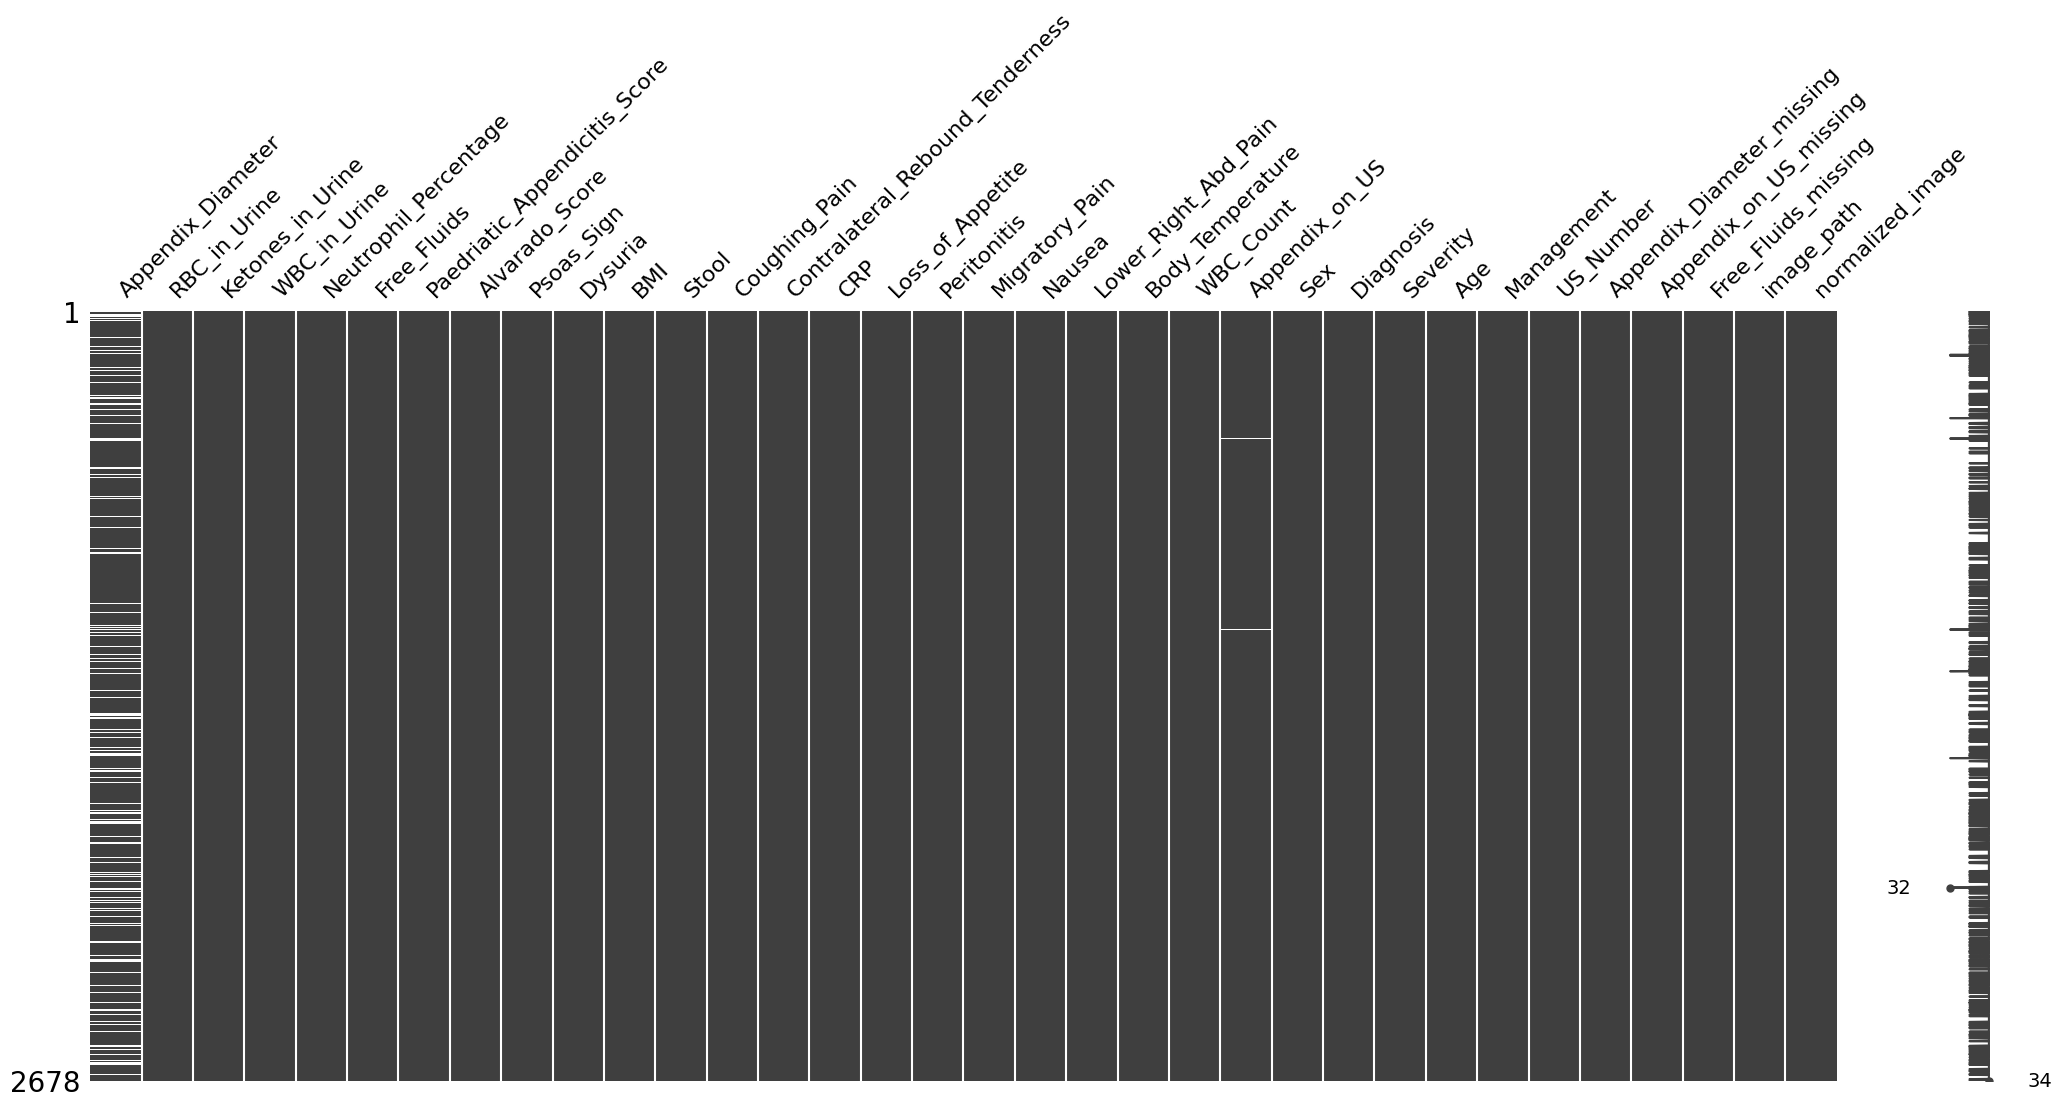

,0
Appendix_Diameter,462
Appendix_on_US,8
RBC_in_Urine,0
Ketones_in_Urine,0
Neutrophil_Percentage,0
WBC_in_Urine,0
Paedriatic_Appendicitis_Score,0
Alvarado_Score,0
Psoas_Sign,0
Free_Fluids,0


In [ ]:
# visualize null values (POST-missingness imputation from MS2)
msno.matrix(df)
plt.show()
df.isnull().sum().sort_values(ascending=False).head(10)

In [ ]:
print(df.dtypes.value_counts())

# summarize numerical predictors
df.describe().T

object     21
float64    10
int64       3
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
Appendix_Diameter,2216.0,-1.090183e-16,1.000226,-1.792520,-0.890410,-0.105967,0.678476,3.816250
Neutrophil_Percentage,2678.0,-5.658075e-16,1.000187,-2.941939,-0.817897,0.189840,0.826287,1.720932
Paedriatic_Appendicitis_Score,2678.0,-2.248637e-16,1.000187,-2.593037,-0.517553,0.001318,0.520189,2.595672
Alvarado_Score,2678.0,-8.556760e-17,1.000187,-2.575485,-0.728003,0.195738,0.657608,2.043220
BMI,2678.0,7.349527e-16,1.000187,-2.664248,-0.677631,-0.193306,0.527491,5.006546
CRP,2678.0,-3.847225e-17,1.000187,-0.480082,-0.480082,-0.369672,-0.016363,7.579789
Body_Temperature,2678.0,-1.225806e-15,1.000187,-1.831715,-0.662108,-0.142282,0.637456,3.756409
WBC_Count,2678.0,7.893445e-17,1.000187,-1.840585,-0.779347,-0.178647,0.702381,5.187613
Age,2678.0,-1.134268e-16,1.000187,-3.434460,-0.600983,-0.017353,0.738644,1.969407
US_Number,2678.0,4.306397e+02,278.117470,1.000000,196.000000,393.000000,624.000000,992.000000


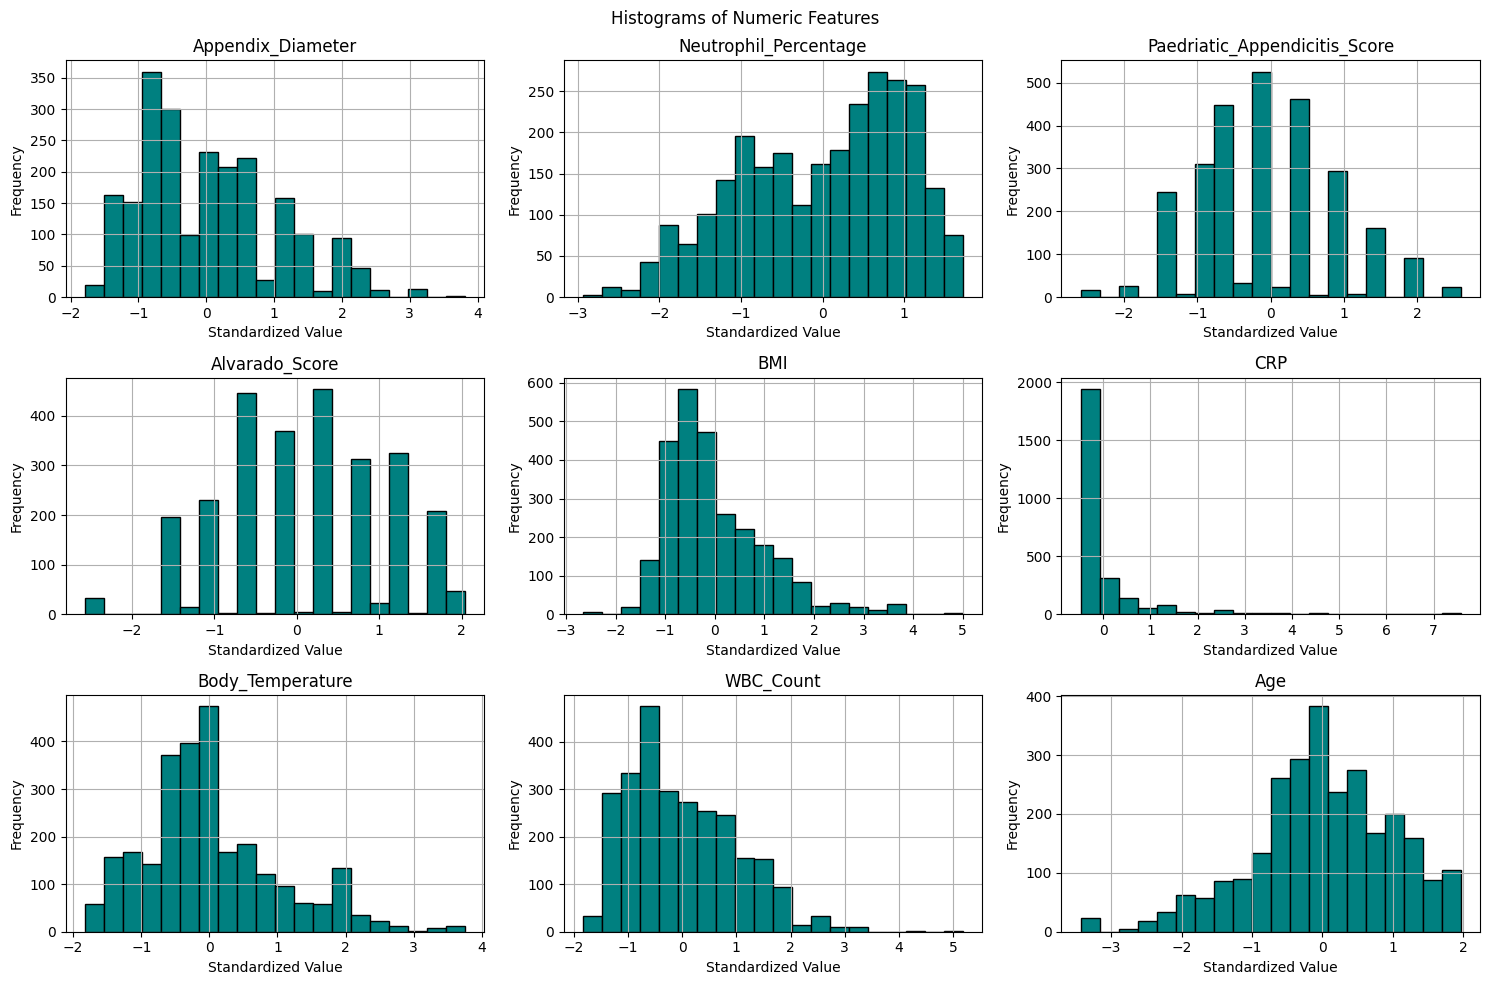

In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# excludes missingness indicator predictors + 'US_Number' (identifier - not useful for analysis/modeling) & response var
exclude_cols = ['US_Number', 'Diagnosis_encoded']
numeric_predictors = [col for col in numeric_cols if 'missing' not in col and col not in exclude_cols]

axes = df[numeric_predictors].hist(bins=20, figsize=(15, 10), color='teal', edgecolor='black')

# Iterate through each Axes object and set the labels
for ax in axes.flatten():
    ax.set_xlabel("Standardized Value")      # Set x-axis label (you can change "Value" as needed)
    ax.set_ylabel("Frequency")  # Set y-axis label

plt.suptitle("Histograms of Numeric Features")
plt.tight_layout()
plt.show()

These plots show that all numeric features were properly standardized. Some features, like CRP, WBC_Count, and Appendix_Diameter, are right-skewed, which might reflect higher values in patients with appendicitis. Scoring features show expected discrete patterns, and Age is slightly skewed. These patterns aren’t a concern for most models but could matter if we later use regression methods that assume normally distributed inputs.


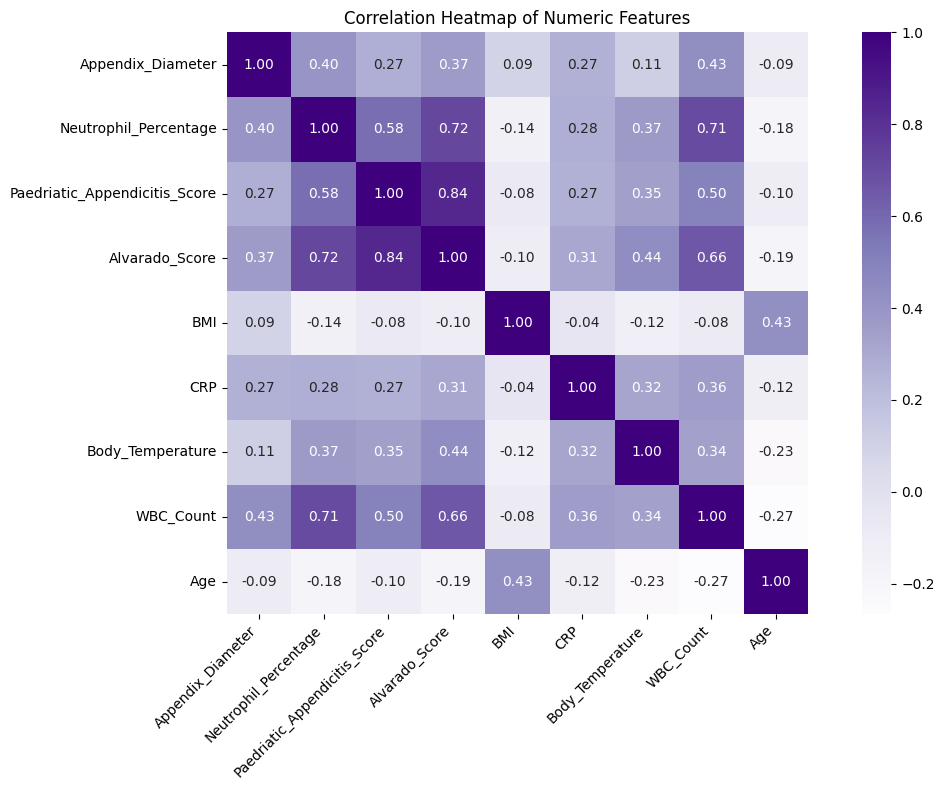

In [ ]:
corr_df = df[numeric_predictors].copy()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_df.corr(), annot=True, fmt=".2f", cmap='Purples', square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The Paediatric Appendicitis Score and Alvarado Score are very strongly correlated (0.84), which makes sense since they’re both based on similar clinical signs and lab results. Both scores also have moderate correlations with WBC Count (0.50–0.66) and Neutrophil Percentage (0.58–0.72), which are key indicators of infection. CRP is less strongly correlated but still aligns with these lab markers. Appendix Diameter shows moderate correlation with WBC Count (0.43) and Neutrophils (0.40), suggesting it tends to increase when inflammation is present. BMI and Age don’t show strong correlations with other features and may be less important for prediction.

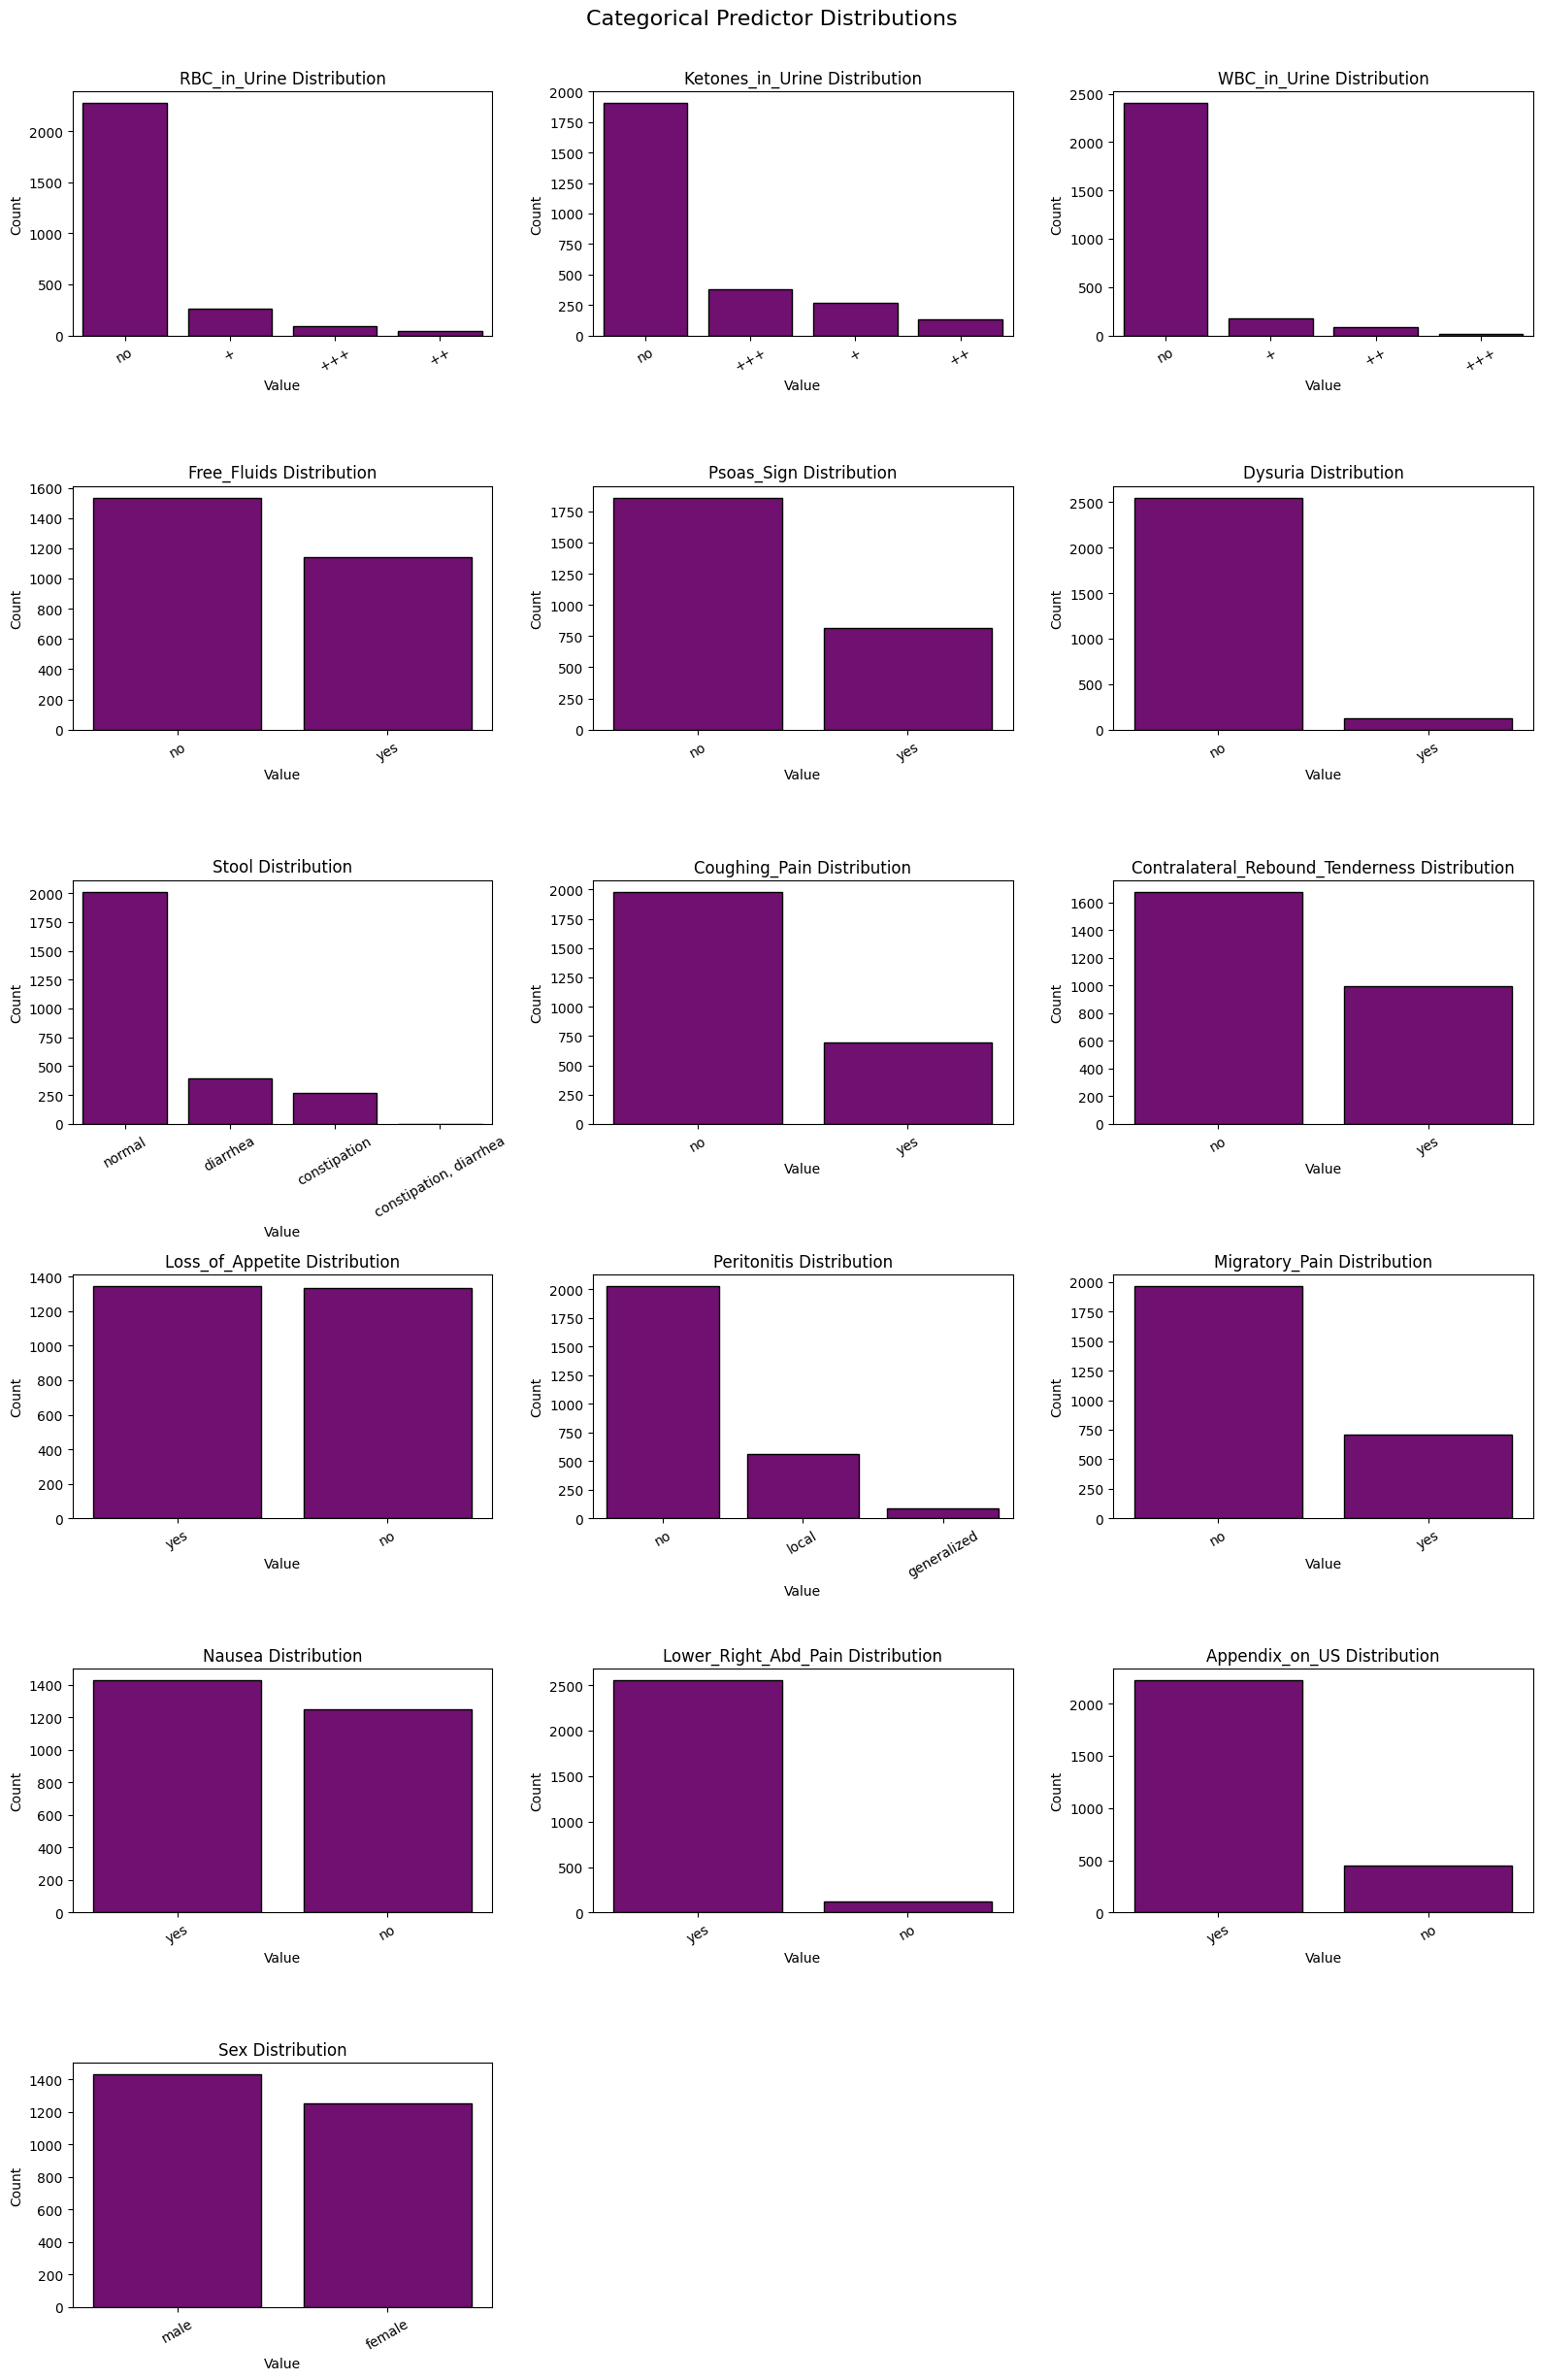

In [ ]:
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# exclude target and image columns
exclude_cols = ['Diagnosis', 'Severity', 'Management', 'image_path', 'normalized_image']
categorical_predictors = [col for col in categorical_cols if col not in exclude_cols]

n_cols = 3
n_rows = -(-len(categorical_predictors) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_predictors):
    sns.countplot(x=col, data=df, ax=axes[i], order=df[col].value_counts().index, color='purple', edgecolor='black')
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=30)

# hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Categorical Predictor Distributions', fontsize=16, y=1.02)
plt.show()

In Milestone 2, we upsampled the minority class (`no appendicitis`) by duplicating rows with replacement to balance the `Diagnosis` response variable. This ensures the model sees an equal number of cases from each class during training.

As a result, the count plots above reflect the post-upsampling dataset and include duplicated rows from the minority class. While they don’t represent the original data distribution, they are helpful for understanding what the model is trained on.

Most clinical signs, such as `Psoas_Sign`, `Dysuria`, and `Migratory_Pain`, appear to be absent in most patients. Although these counts come from the upsampled data, the imbalance between "yes" and "no" responses remains and supports this interpretation. Urine test results are heavily skewed toward "no" or low levels. In contrast, features like `Nausea`, `Loss_of_Appetite`, and `Free_Fluids` are more evenly distributed, which may indicate stronger predictive value. `Sex` is fairly balanced across the dataset and is unlikely to require adjustment.

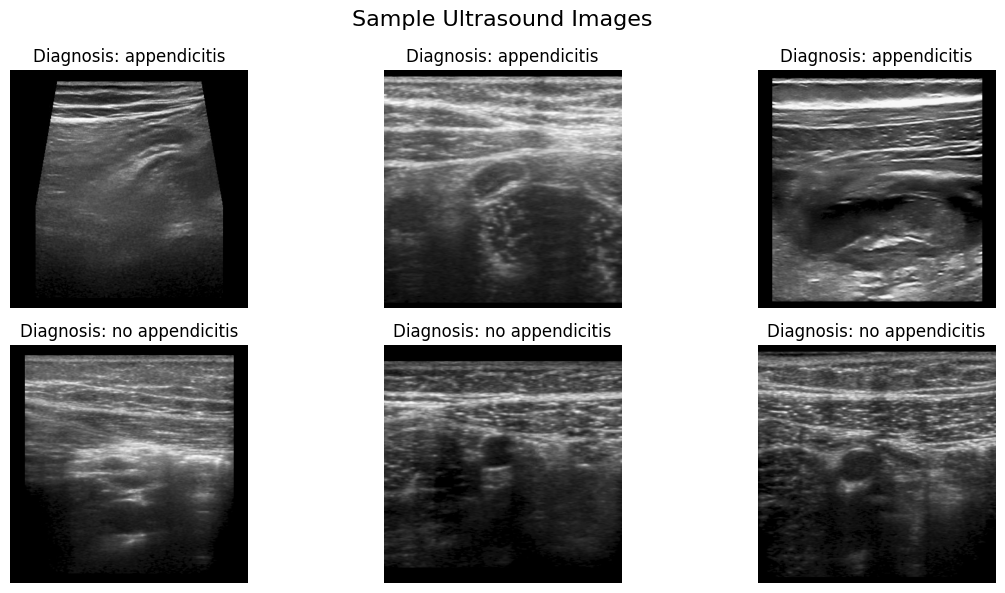

In [ ]:
# display a few example ultrasound images

# sample 3 from each class
sample_yes = df[df['Diagnosis'] == 'appendicitis'].sample(3, random_state=1)
sample_no = df[df['Diagnosis'] == 'no appendicitis'].sample(3, random_state=1)

# combine and reset index
sample_rows = pd.concat([sample_yes, sample_no]).reset_index(drop=True)

plt.figure(figsize=(12, 6))

for i, (_, row) in enumerate(sample_rows.iterrows()):
    img_array = np.array(row['normalized_image'])

    plt.subplot(2, 3, i + 1)
    plt.imshow(img_array, cmap='gray')
    plt.axis('off')
    plt.title(f"Diagnosis: {row['Diagnosis']}")

plt.suptitle("Sample Ultrasound Images", fontsize=16)
plt.tight_layout()
plt.show()

<a name="data-analysis"></a>
# Data Analysis

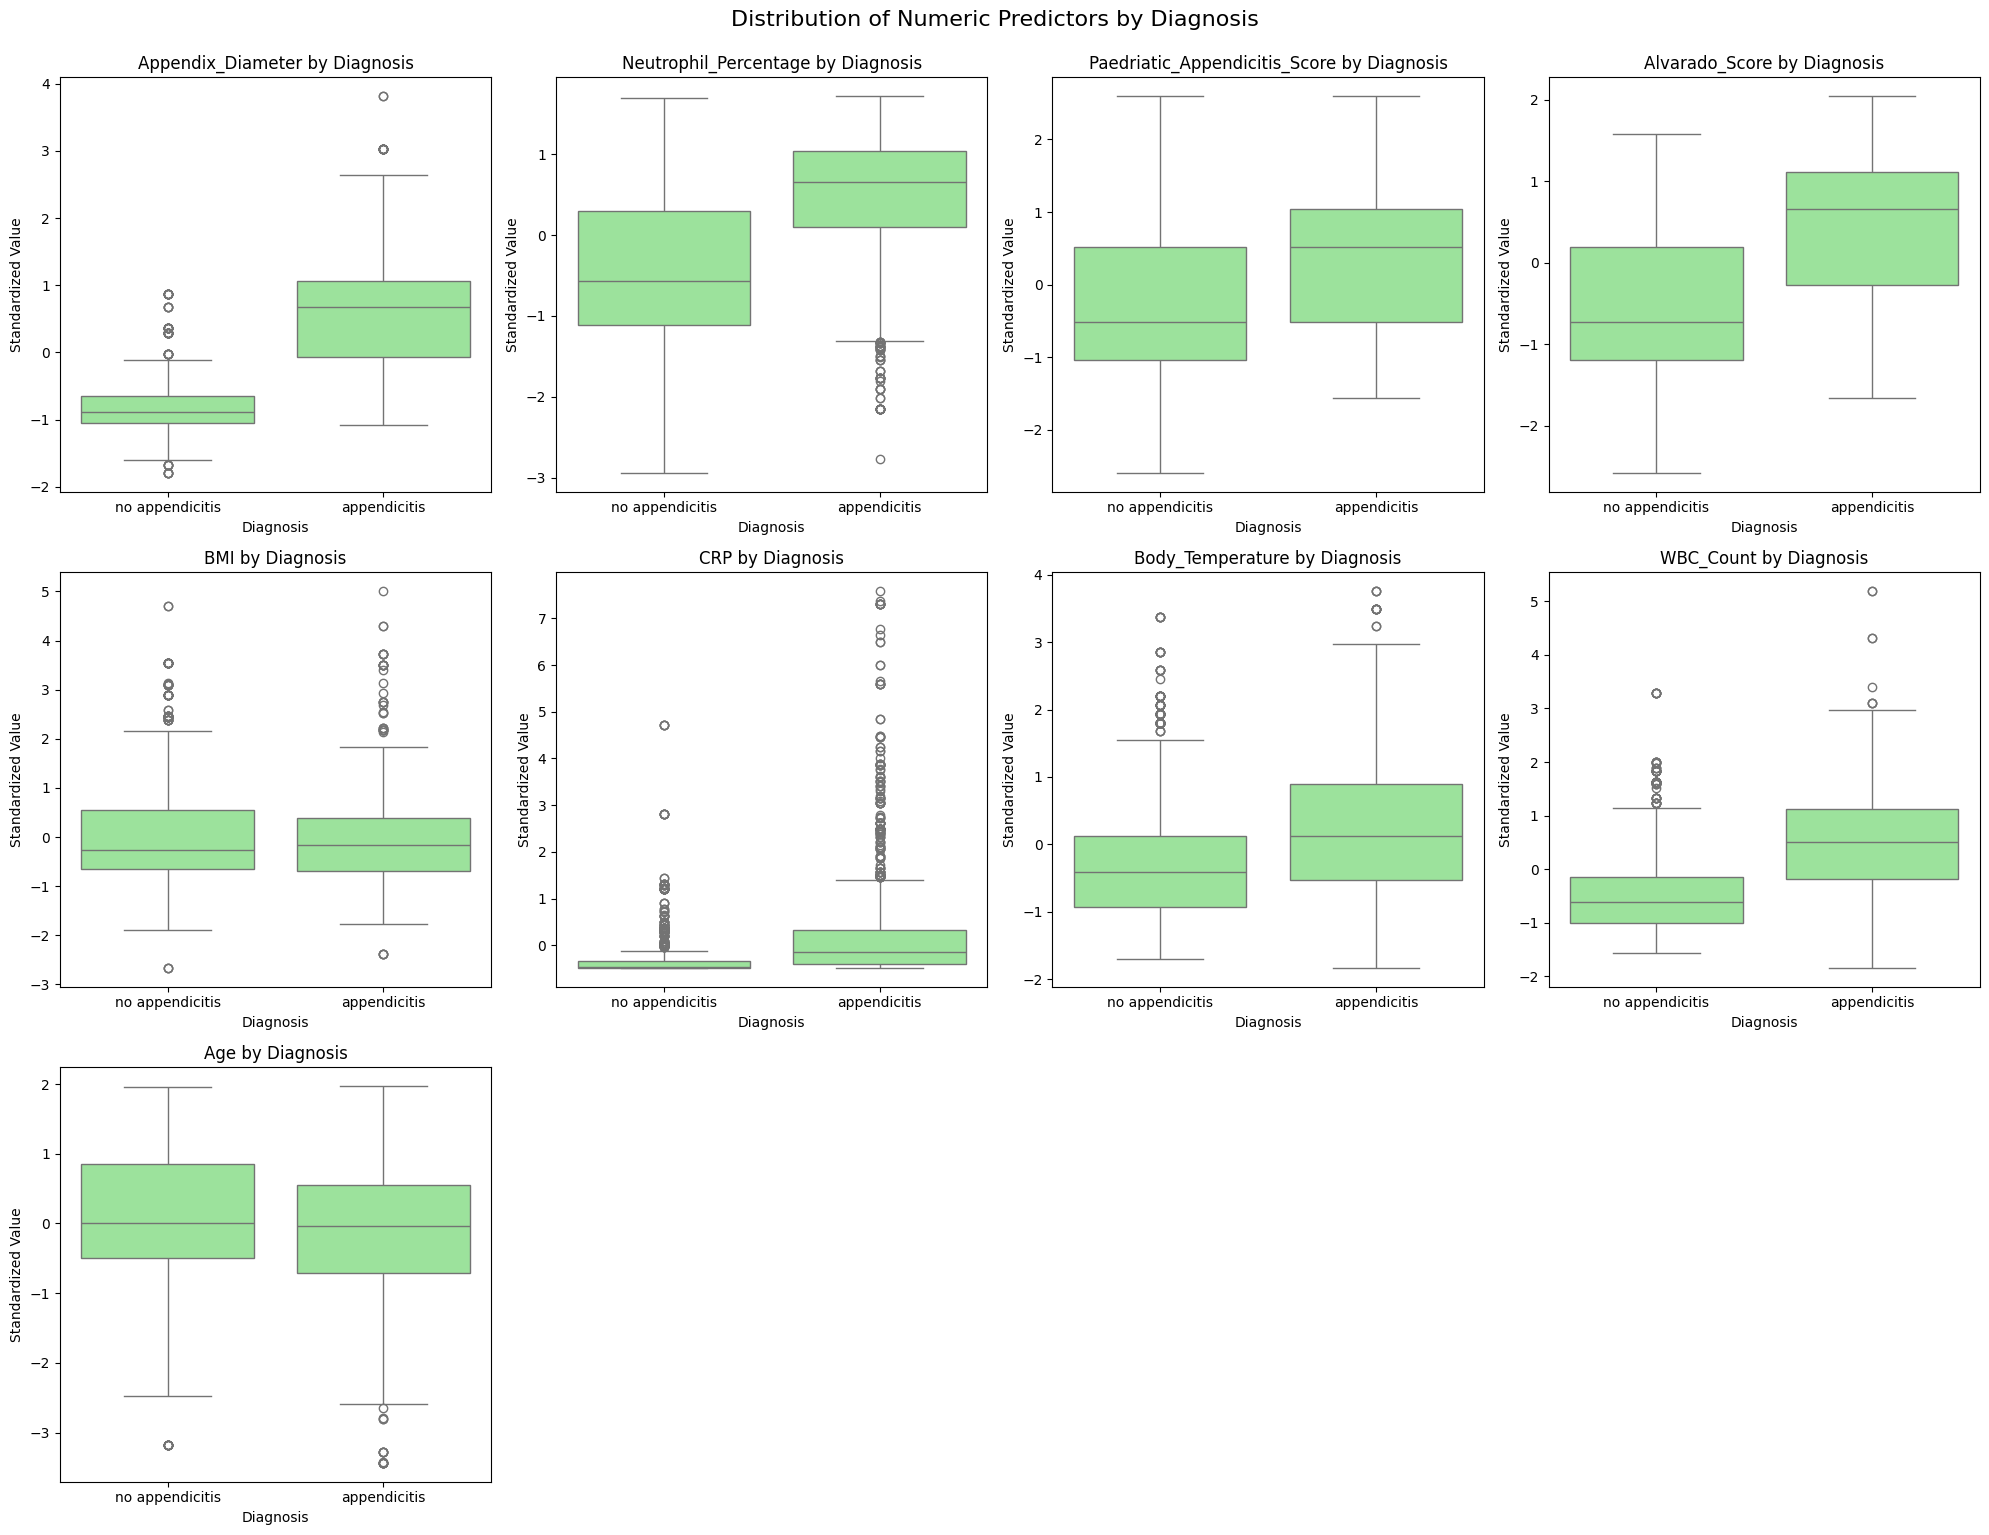

In [ ]:
n_cols = 4
n_rows = -(-len(numeric_predictors) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_predictors):
    sns.boxplot(x='Diagnosis', y=col, data=df, ax=axes[i], color='lightgreen')
    axes[i].set_title(f'{col} by Diagnosis')
    axes[i].set_xlabel('Diagnosis')
    axes[i].set_ylabel('Standardized Value')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Distribution of Numeric Predictors by Diagnosis', fontsize=16, y=1.02)
plt.show()

In [ ]:
Q1 = df['CRP'].quantile(0.25)
Q3 = df['CRP'].quantile(0.75)
IQR = Q3 - Q1

# define outlier range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# count outliers
outliers = df[(df['CRP'] < lower_bound) | (df['CRP'] > upper_bound)]
print(f"Number of CRP outliers: {outliers.shape[0]}")

Number of CRP outliers: 293


Several numeric features show clear differences between patients with and without appendicitis. Inflammatory markers like CRP, WBC Count, and Neutrophil Percentage tend to be higher in the appendicitis group, along with clinical scores like the Paediatric Appendicitis Score and Alvarado Score. Appendix Diameter is also noticeably larger in those with appendicitis, which aligns with clinical expectations. Other features like BMI and Age show less distinction between groups. Outliers are present across several features, especially in CRP, where 293 patients fall outside the typical range—likely reflecting real cases of severe inflammation rather than data issues. These patterns suggest that certain lab values and clinical scores may be useful features for identifying appendicitis.

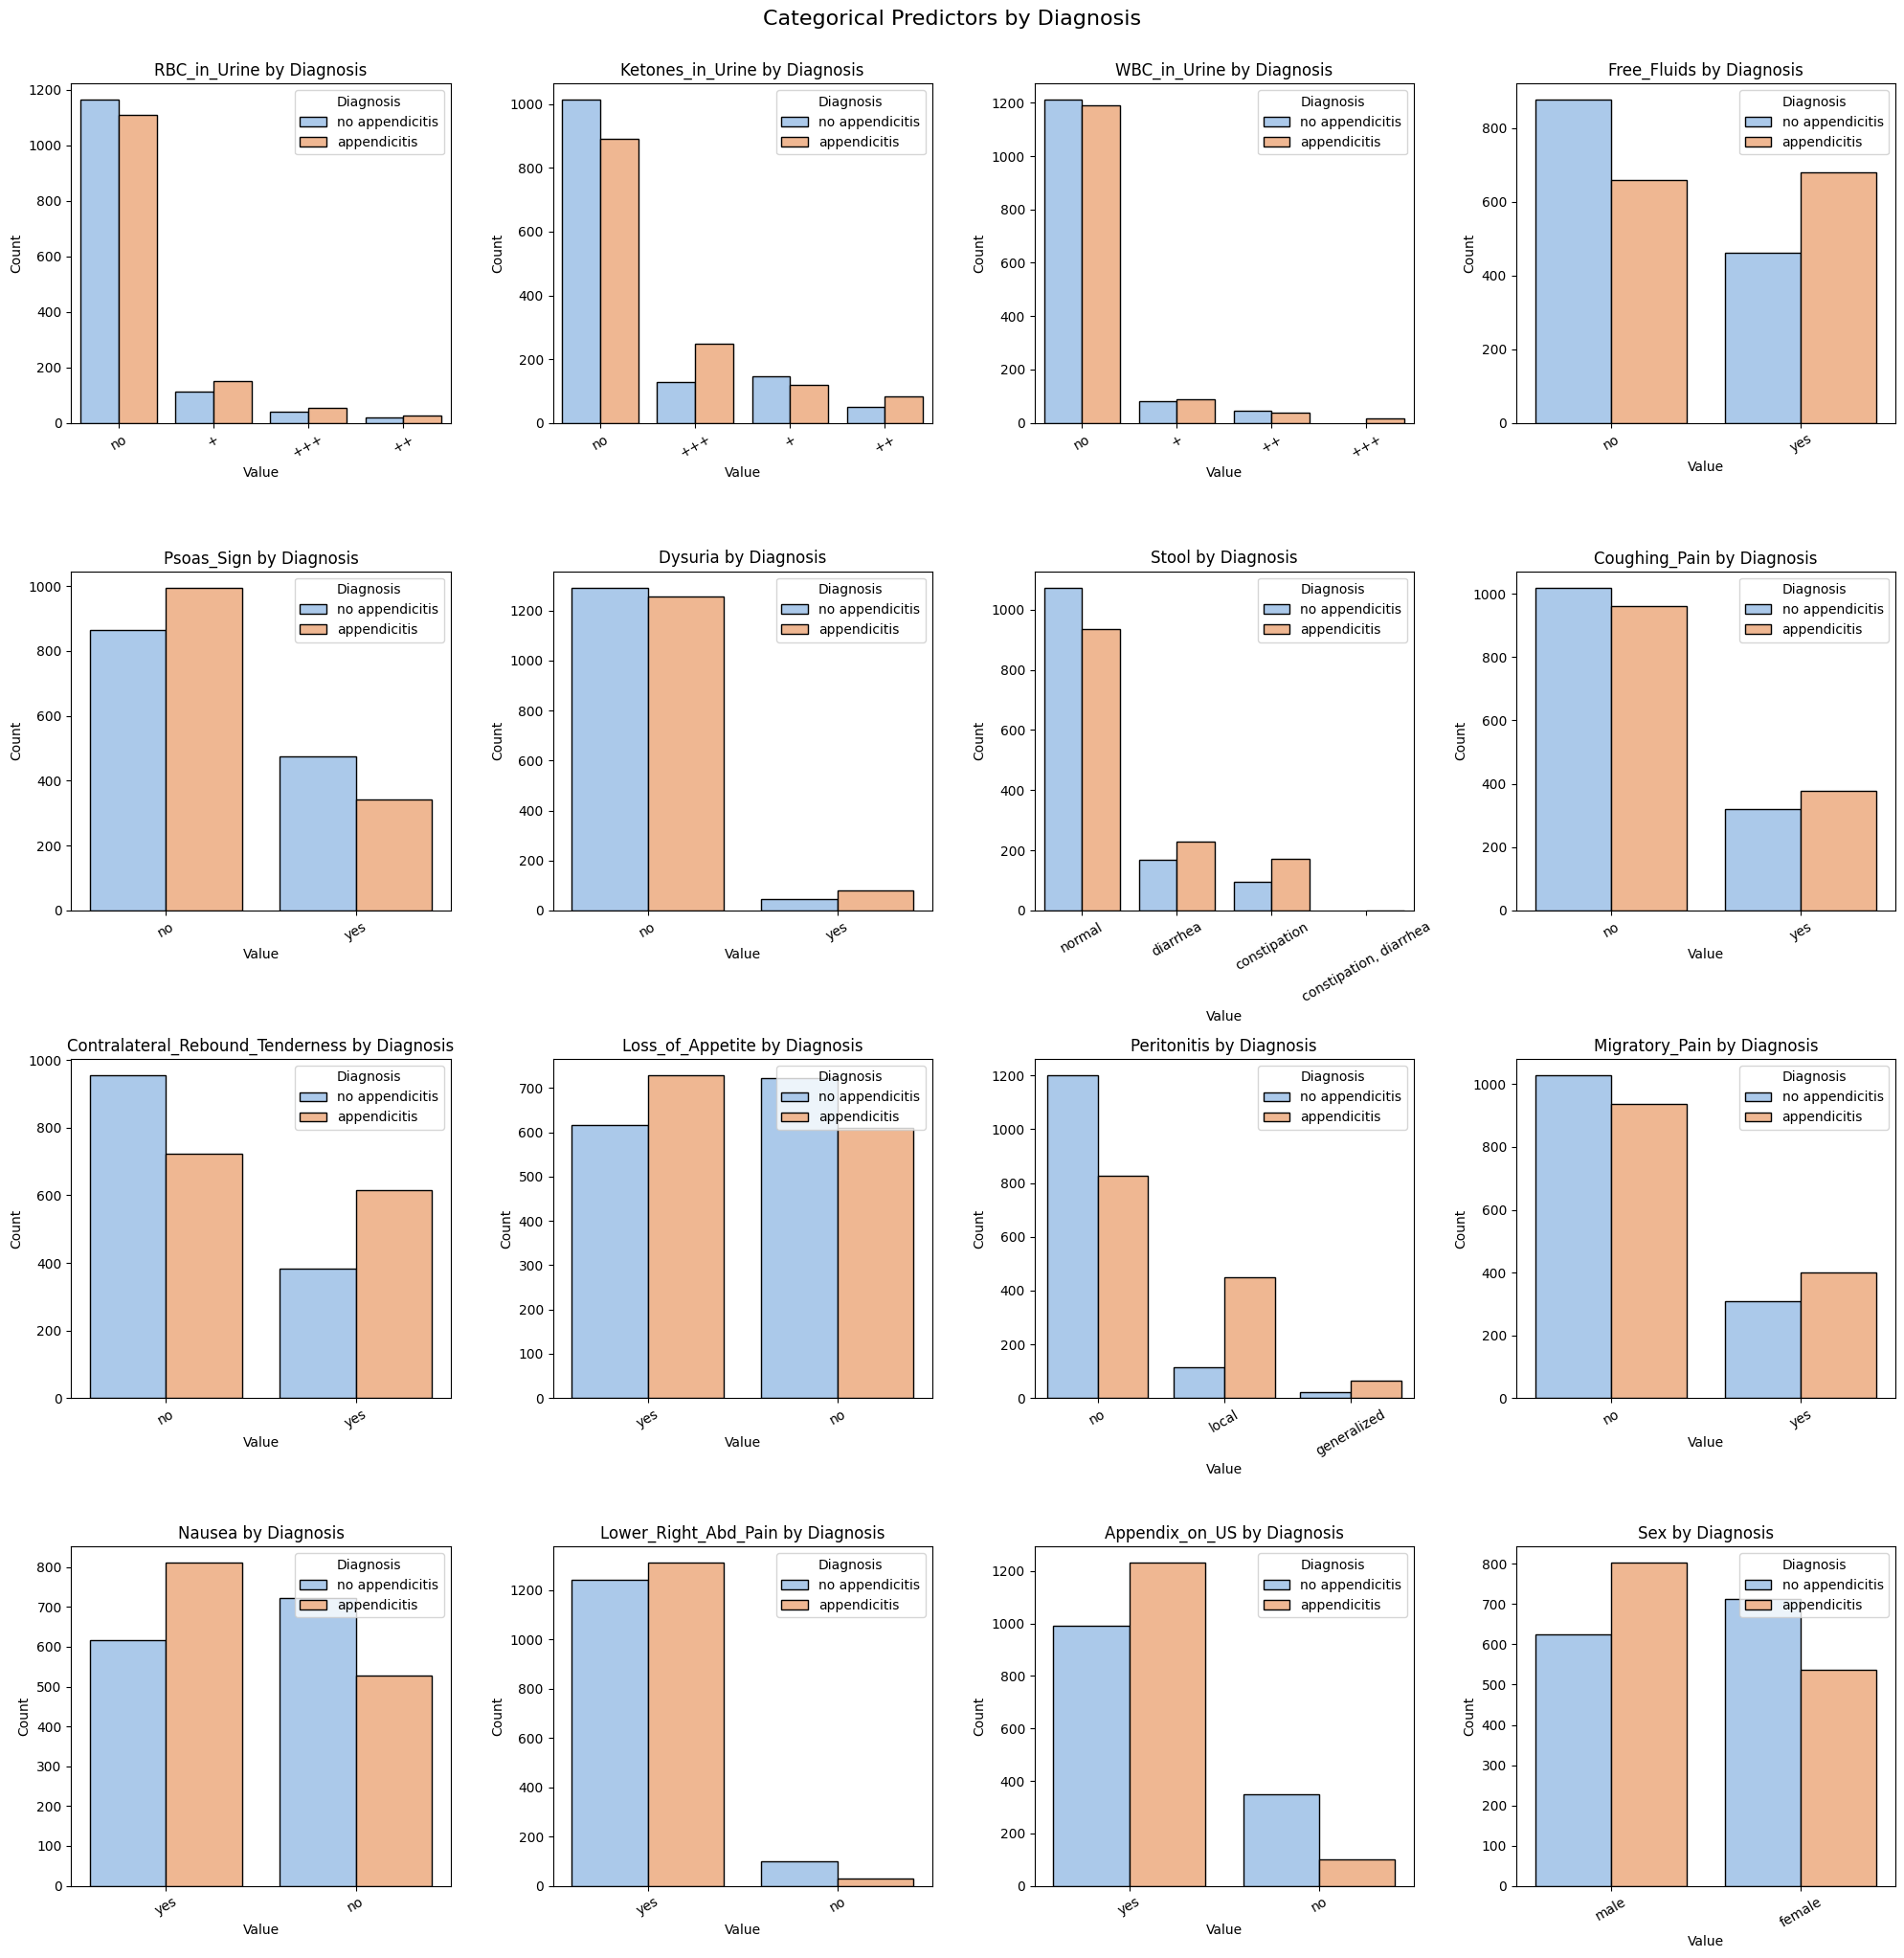

In [ ]:
n_cols = 4
n_rows = -(-len(categorical_predictors) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_predictors):
    sns.countplot(x=col, hue='Diagnosis', data=df, ax=axes[i],
                  order=df[col].value_counts().index, palette='pastel', edgecolor='black')
    axes[i].set_title(f'{col} by Diagnosis')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=30)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Categorical Predictors by Diagnosis', fontsize=16, y=1.02)
plt.show()


Several categorical predictors show clear differences between patients with and without appendicitis. A higher proportion of patients with appendicitis reported `Nausea` and `Loss_of_Appetite`, both commonly associated with the condition. `Appendix_on_US` was more often visible in appendicitis cases, likely reflecting its diagnostic relevance. In contrast, `Lower_Right_Abd_Pain` was reported by nearly all patients regardless of diagnosis, making it less helpful for distinguishing between groups. A mild sex-related trend is also present, with more males in the appendicitis group and more females in the non-appendicitis group, though this may reflect demographic patterns rather than a true predictive signal.

Other clinical signs—such as `Migratory_Pain`, `Psoas_Sign`, `Contralateral_Rebound_Tenderness`, and `Coughing_Pain`—appear more frequently in appendicitis cases, though "no" remains the most common response overall. `Peritonitis`, though less frequent, is strongly associated with appendicitis when classified as "local" or "generalized." In contrast, features like `Dysuria` and abnormal urine findings (`RBC_in_Urine`, `WBC_in_Urine`, `Ketones_in_Urine`) are more common in non-appendicitis cases, suggesting they may help rule out the condition. `Free_Fluids` shows a more even split and may offer additional predictive value when considered alongside other features.

In [ ]:
# chi-squared test for categorical variables
for col in categorical_predictors:
    table = pd.crosstab(df[col], df['Diagnosis'])
    chi2, p, _, _ = chi2_contingency(table)
    print(f"{col}: p = {p:.5f}")


RBC_in_Urine: p = 0.02996
Ketones_in_Urine: p = 0.00000
WBC_in_Urine: p = 0.00029
Free_Fluids: p = 0.00000
Psoas_Sign: p = 0.00000
Dysuria: p = 0.00199
Stool: p = 0.00000
Coughing_Pain: p = 0.00940
Contralateral_Rebound_Tenderness: p = 0.00000
Loss_of_Appetite: p = 0.00002
Peritonitis: p = 0.00000
Migratory_Pain: p = 0.00008
Nausea: p = 0.00000
Lower_Right_Abd_Pain: p = 0.00000
Appendix_on_US: p = 0.00000
Sex: p = 0.00000


In [ ]:
# t-test for numeric variables
for col in numeric_predictors:
    group1 = df[df['Diagnosis'] == 'appendicitis'][col].dropna()
    group2 = df[df['Diagnosis'] == 'no appendicitis'][col].dropna()
    tstat, p = ttest_ind(group1, group2)
    print(f"{col}: p = {p:.5f}")

Appendix_Diameter: p = 0.00000
Neutrophil_Percentage: p = 0.00000
Paedriatic_Appendicitis_Score: p = 0.00000
Alvarado_Score: p = 0.00000
BMI: p = 0.04035
CRP: p = 0.00000
Body_Temperature: p = 0.00000
WBC_Count: p = 0.00000
Age: p = 0.00000


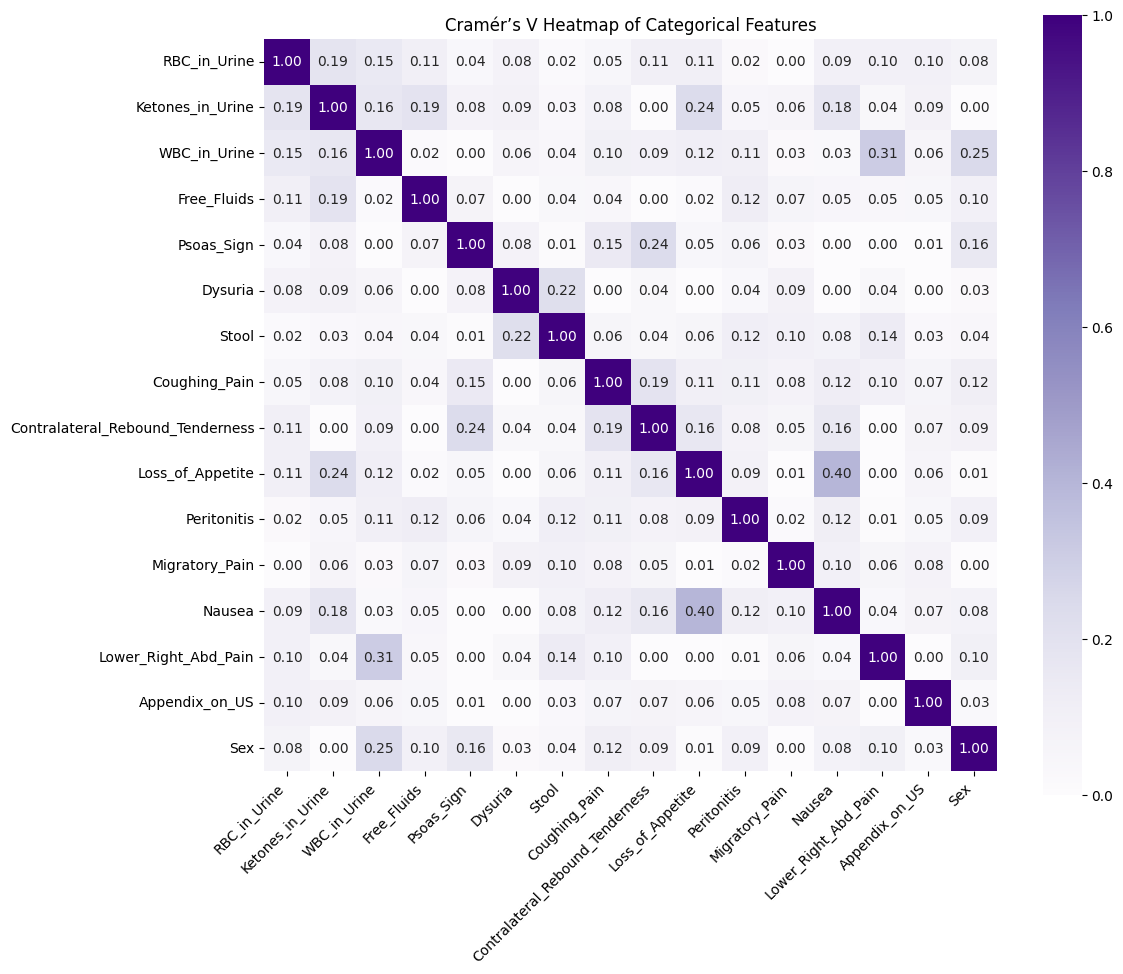

In [ ]:
# define Cramér’s V function (bias-corrected version)
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramer_matrix = pd.DataFrame(np.zeros((len(categorical_predictors), len(categorical_predictors))),
                             index=categorical_predictors, columns=categorical_predictors)

for col1 in categorical_predictors:
    for col2 in categorical_predictors:
        cramer_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

plt.figure(figsize=(12, 10))
sns.heatmap(cramer_matrix, annot=True, cmap='Purples', fmt=".2f", square=True)
plt.title("Cramér’s V Heatmap of Categorical Features")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The Cramér’s V heatmap shows that most categorical predictors are not strongly related to one another, with no values above 0.5. This suggests there's little redundancy across features. A few moderate associations stand out: `Loss_of_Appetite` and `Nausea` show a value of 0.40, which makes sense since these symptoms often occur together. `Lower_Right_Abd_Pain` and `WBC_in_Urine` have a value of 0.31, which could be worth checking more closely. `Sex` also shows a mild association with `WBC_in_Urine` (0.25), possibly reflecting biological differences. These patterns are useful to keep in mind when deciding which features to keep or combine.

Overall, there doesn't appear to be meaningful redundancy across the predictor variables, either numeric or categorical. The relationships between variables have been explored thoroughly through correlation matrices, Cramér’s V, and statistical tests (chi-squared and t-tests), all of which support moving forward with a diverse and informative set of features.

In clinical data, variables like `Sex`, `Age`, and `BMI` often influence both how a condition presents and how it’s diagnosed. To account for this, we’ll include them in our model to adjust for potential confounding. That said, some confounders may not be captured in our dataset. Factors such as socioeconomic status, access to care, existing health conditions, and delays in seeking treatment could influence both the predictors and the diagnosis, potentially biasing the model. There may also be other important confounders that aren’t apparent from the data alone and would require clinical expertise to identify, which is an important limitation to keep in mind when interpreting our results.

<a name="project-question"></a>
# (Revised) Project Question

How can we develop a multimodal model that combines ultrasound imaging with key clinical features to improve diagnostic accuracy and enhance interpretability for pediatric appendicitis, using CNNs and saliency maps to provide localized, clinically relevant explanations?

<a name="baseline-model"></a>
# Baseline Model and Implementation Plan

To establish a strong starting point, we began with a baseline model using only the tabular clinical data. This allowed us to evaluate how much predictive signal exists in the structured features before incorporating imaging. Our initial model was logistic regression, with plans to follow up with a feedforward neural network or random forest. All available predictors were included (excluding identifiers, targets, and image-related fields), and we will later use permutation importance or similar methods to identify the most relevant features. The target variable is `Diagnosis` (appendicitis vs. no appendicitis), and model performance is evaluated using accuracy, F1-score, ROC-AUC, and a confusion matrix. We use an 80/20 stratified train-test split and explicitly include `Sex`, `Age`, and `BMI` to adjust for potential confounding.

In parallel, we developed a baseline image-only model using a convolutional neural network (CNN) trained on grayscale ultrasound images from the `normalized_image` field. The CNN predicts the same `Diagnosis` label, and saliency maps such as Grad-CAM will be used to visualize which regions of the image the model attends to. These visualizations are central to our interpretability goal. The baseline CNN architecture is intentionally simple: two convolutional layers followed by max-pooling, a fully connected layer, and a sigmoid output. This lightweight structure enables fast training while still capturing key visual patterns. Looking ahead, we may explore training an autoencoder to learn compact, meaningful image representations that could enhance downstream classification. While this isn’t part of the current milestone, it remains a promising future direction.

Next, we will build a multimodal model that combines both clinical and imaging data. Tabular features will pass through a feedforward neural network and image data through a CNN encoder. The outputs will then be merged—either early in the network or at the decision stage—and passed through a final classification layer. This approach allows the model to learn from both data modalities while supporting interpretability through saliency maps and feature analysis, ultimately producing more transparent and clinically relevant predictions.


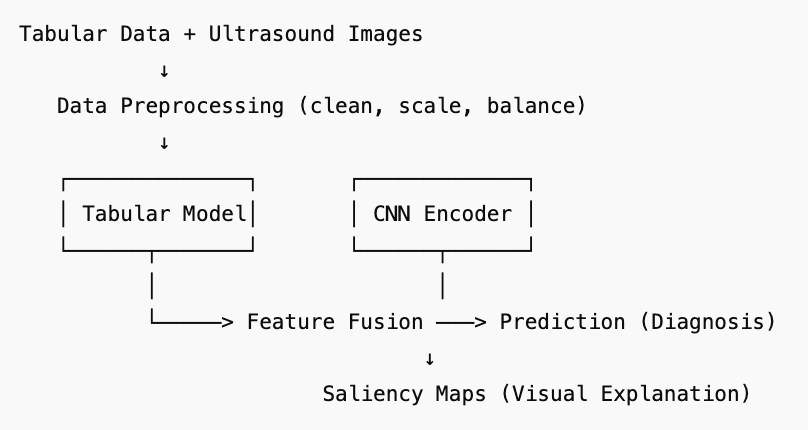

In [ ]:
# reminder of the state of our data frame:
# numeric predictors are standardized, but categorical predictors are not encoded yet

print(df.shape)
df.head(5)

(2678, 34)


,Appendix_Diameter,RBC_in_Urine,Ketones_in_Urine,WBC_in_Urine,Neutrophil_Percentage,Free_Fluids,Paedriatic_Appendicitis_Score,Alvarado_Score,Psoas_Sign,Dysuria,...,Diagnosis,Severity,Age,Management,US_Number,Appendix_Diameter_missing,Appendix_on_US_missing,Free_Fluids_missing,image_path,normalized_image
0,-0.890410,no,no,no,-2.593963,yes,-1.555295,-1.651744,yes,no,...,no appendicitis,uncomplicated,-0.026425,conservative,721.0,0,0,0,../data/US_Pictures_Clean/721.3_App.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,NaN,++,+++,no,0.454302,yes,0.001318,0.657608,no,no,...,no appendicitis,uncomplicated,-1.992018,conservative,374.0,1,0,0,../data/US_Pictures_Clean/374.1_RLQ_app_not_vi...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0.286255,+,+++,no,1.352078,no,2.076801,1.581349,no,no,...,appendicitis,uncomplicated,-1.777315,primary surgical,564.0,0,0,0,../data/US_Pictures_Clean/564.2_App_M.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,NaN,no,+,++,-1.111588,yes,-0.517553,-0.266133,yes,no,...,no appendicitis,uncomplicated,-0.594935,conservative,212.0,1,0,0,../data/US_Pictures_Clean/212.1_RLQ.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,-0.498189,no,no,no,-2.148555,yes,-1.036424,-0.266133,no,no,...,appendicitis,uncomplicated,-0.313704,primary surgical,525.0,0,0,0,../data/US_Pictures_Clean/525.10_App.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


To prepare the categorical variables for modeling, we chose an encoding method based on the number of categories and whether they had any meaningful order. Binary features with two categories (like 'yes'/'no' or 'male'/'female') were label encoded as 0 and 1. For features with more than two categories and no clear order, we used one-hot encoding to represent each category separately. We didn’t apply ordinal encoding since none of the categorical features had a logical ranking.

In [ ]:
for col in categorical_predictors:
    unique_vals = df[col].dropna().unique()
    print(f"{col}: {unique_vals}")

RBC_in_Urine: ['no' '++' '+' '+++']
Ketones_in_Urine: ['no' '+++' '+' '++']
WBC_in_Urine: ['no' '++' '+' '+++']
Free_Fluids: ['yes' 'no']
Psoas_Sign: ['yes' 'no']
Dysuria: ['no' 'yes']
Stool: ['normal' 'constipation' 'diarrhea' 'constipation, diarrhea']
Coughing_Pain: ['no' 'yes']
Contralateral_Rebound_Tenderness: ['no' 'yes']
Loss_of_Appetite: ['no' 'yes']
Peritonitis: ['local' 'no' 'generalized']
Migratory_Pain: ['no' 'yes']
Nausea: ['no' 'yes']
Lower_Right_Abd_Pain: ['yes' 'no']
Appendix_on_US: ['yes' 'no']
Sex: ['female' 'male']


In [ ]:
binary_categoricals = [
    'Free_Fluids', 'Psoas_Sign', 'Dysuria', 'Coughing_Pain',
    'Contralateral_Rebound_Tenderness', 'Loss_of_Appetite',
    'Migratory_Pain', 'Nausea', 'Lower_Right_Abd_Pain',
    'Appendix_on_US', 'Sex'
]

multiclass_categoricals = [
    'RBC_in_Urine', 'Ketones_in_Urine', 'WBC_in_Urine',
    'Stool', 'Peritonitis'
]

df_encoded = df.copy()

# encode response variable (binary)
df_encoded['Diagnosis_encoded'] = df_encoded['Diagnosis'].map({'no appendicitis': 0, 'appendicitis': 1})

# label encode binary variables (yes/no, male/female)
label_map = {'no': 0, 'yes': 1, 'female': 0, 'male': 1}
for col in binary_categoricals:
    df_encoded[col] = df_encoded[col].map(label_map)

# one-hot encode multiclass categorical variables
df_encoded = pd.get_dummies(df_encoded, columns=multiclass_categoricals, drop_first=True) # drop_first=True prevents multicollinearity

print("Encoded DataFrame shape:", df_encoded.shape)
df_encoded.head()

Encoded DataFrame shape: (2678, 44)


,Appendix_Diameter,Neutrophil_Percentage,Free_Fluids,Paedriatic_Appendicitis_Score,Alvarado_Score,Psoas_Sign,Dysuria,BMI,Coughing_Pain,Contralateral_Rebound_Tenderness,...,Ketones_in_Urine_+++,Ketones_in_Urine_no,WBC_in_Urine_++,WBC_in_Urine_+++,WBC_in_Urine_no,"Stool_constipation, diarrhea",Stool_diarrhea,Stool_normal,Peritonitis_local,Peritonitis_no
0,-0.890410,-2.593963,1,-1.555295,-1.651744,1,0,-0.319762,0,0,...,False,True,False,False,True,False,False,True,True,False
1,NaN,0.454302,1,0.001318,0.657608,0,0,-1.088611,0,0,...,True,False,False,False,True,False,False,True,False,True
2,0.286255,1.352078,0,2.076801,1.581349,0,0,-0.764885,1,1,...,True,False,False,False,True,False,False,True,False,False
3,NaN,-1.111588,1,-0.517553,-0.266133,1,0,-0.871108,0,0,...,False,False,True,False,False,False,False,True,False,True
4,-0.498189,-2.148555,1,-1.036424,-0.266133,0,0,-0.936865,0,1,...,False,True,False,False,True,False,False,True,False,True


In [ ]:
# drop target + non-predictive columns
exclude_cols = ['Diagnosis', 'Severity', 'Management', 'Diagnosis_encoded',
                'image_path', 'normalized_image', 'US_Number']


X = df_encoded.drop(columns=exclude_cols)
y = df_encoded['Diagnosis_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=109)

In [ ]:
# fit model

# fill all remaining NaNs in X with 0
# this is reasonable because numerical features are standardized (mean ≈ 0),
# and missingness is already captured by corresponding _missing indicator columns
X_train_filled = X_train.fillna(0)
X_test_filled = X_test.fillna(0)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_filled, y_train)

y_pred = lr.predict(X_test_filled)
y_prob = lr.predict_proba(X_test_filled)[:, 1]

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       268
           1       0.93      0.90      0.92       268

    accuracy                           0.92       536
   macro avg       0.92      0.92      0.92       536
weighted avg       0.92      0.92      0.92       536

ROC-AUC: 0.9807724437513923


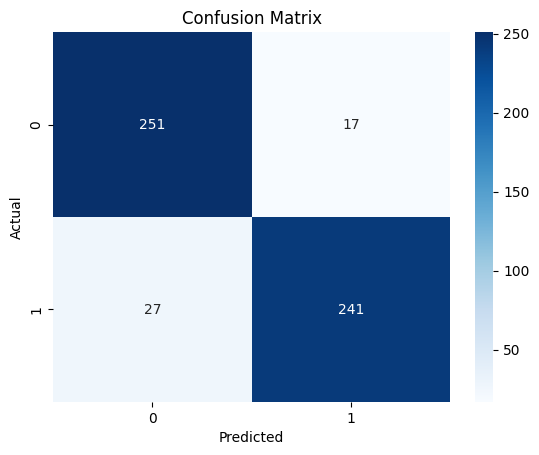

In [ ]:
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

display(coef_df.head(10))  # top 10 features

,Feature,Coefficient
0,Appendix_Diameter,4.909625
20,Appendix_Diameter_missing,-3.097802
21,Appendix_on_US_missing,2.910959
24,RBC_in_Urine_+++,-2.060469
26,Ketones_in_Urine_++,1.537449
36,Peritonitis_no,-1.141975
30,WBC_in_Urine_+++,1.031120
4,Alvarado_Score,1.030414
28,Ketones_in_Urine_no,0.852684
6,Dysuria,-0.825030


In [ ]:
shapes = df['normalized_image'].apply(lambda x: np.array(x).shape)
print("Unique image shapes:", shapes.unique())

Unique image shapes: [(400, 400)]


In [ ]:
# encode response variable (binary)
df['Diagnosis_encoded'] = df['Diagnosis'].map({'no appendicitis': 0, 'appendicitis': 1})

# stack all images into a single array
X_images = np.stack(df['normalized_image'].apply(np.array))
# add channel dimension (grayscale → 1 channel)
X_images = X_images[..., np.newaxis]

y = df['Diagnosis_encoded'].values

X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(
    X_images, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train_img.shape)
print("Test shape:", X_test_img.shape)

Train shape: (2142, 400, 400, 1)
Test shape: (536, 400, 400, 1)


In [ ]:
# basic CNN architecture
cnn_model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=X_train_img.shape[1:]),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binary output
])

cnn_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 398, 398, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 199, 199, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 197, 197, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 307328)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    19,669,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,673,921 (75.05 MB)

 Trainable params: 19,673,921 (75.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = cnn_model.fit(X_train_img, y_train_img,
              epochs=10,
              batch_size=32,
              validation_split=0.1)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 249s 4s/step - accuracy: 0.5357 - loss: 1.6820 - val_accuracy: 0.6093 - val_loss: 0.6424
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - accuracy: 0.6723 - loss: 0.6006 - val_accuracy: 0.8186 - val_loss: 0.4457
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 258s 4s/step - accuracy: 0.8576 - loss: 0.3580 - val_accuracy: 0.7488 - val_loss: 0.5196
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 269s 4s/step - accuracy: 0.9279 - loss: 0.1973 - val_accuracy: 0.8744 - val_loss: 0.3822
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 250s 4s/step - accuracy: 0.9862 - loss: 0.0779 - val_accuracy: 0.9070 - val_loss: 0.2732
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 273s 4s/step - accuracy: 0.9976 - loss: 0.0187 - val_accuracy: 0.8884 - val_loss: 0.3301
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.8977 - val_loss: 0.3370
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 0.8930 - v

In [ ]:
loss, acc = cnn_model.evaluate(X_test_img, y_test_img)
print(f"Test Accuracy: {acc:.3f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9360 - loss: 0.2762
Test Accuracy: 0.918


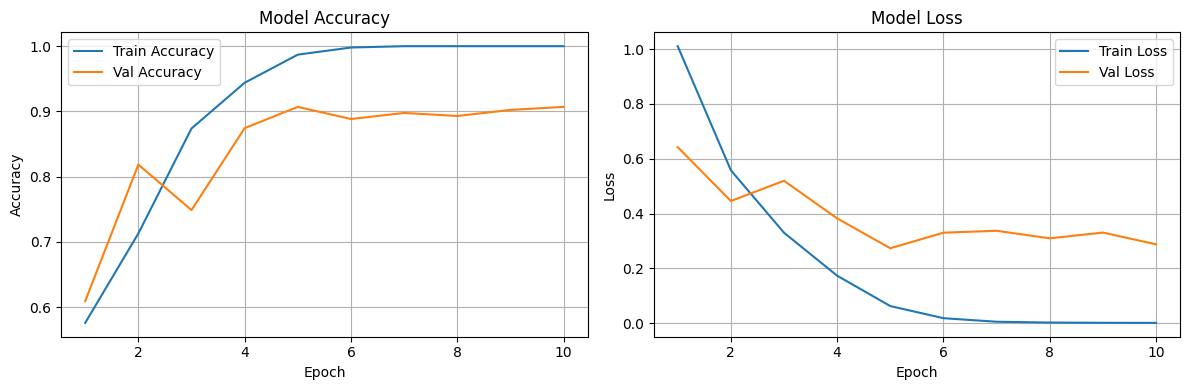

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# plot accuracy
axs[0].plot(epochs, history_dict['accuracy'], label='Train Accuracy')
axs[0].plot(epochs, history_dict['val_accuracy'], label='Val Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].grid(True)
axs[0].legend()

# plot loss
axs[1].plot(epochs, history_dict['loss'], label='Train Loss')
axs[1].plot(epochs, history_dict['val_loss'], label='Val Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()